In [1]:
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme

set_nb_theme('chesterish')

In [2]:
#load libraries 
import time,os
from matplotlib.offsetbox import AnchoredText
import sys,pandas as pd, matplotlib , matplotlib.pyplot as plt, matplotlib.lines , numpy as np,cupy as cp, math, pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#import cudf
#import ROOT
#from ROOT import TFile

#import root_pandas

#from toggle_cell import hide_cell 
import uproot3
%matplotlib inline

#presets for plot style
from scipy.constants import golden
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 7/golden),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

viridis = cm.get_cmap('viridis', 12)
inferno = cm.get_cmap('inferno', 12)
autumn = cm.get_cmap('autumn', 12)

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.experimental.set_memory_growth(physical_devices[1], True)
rc = plt.rc
rc('text', usetex=False)
import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=15)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

import root_pandas,glob

import gc

def read_n(pattern, n):
    if not '*' in pattern:
        a = root_pandas.read_root(pattern,chunksize=int(n))
    else:
        a = root_pandas.read_root(glob.glob(pattern),chunksize=int(n))
    for b in a:
        del a
        print(n)
        return b

from scipy.optimize import curve_fit

image_dir='images'

import misc_util,correlation_plots

import imp
imp.reload(correlation_plots)

/home/sebouh/.local/lib/python3.8/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/home/sebouh/.local/lib/python3.8/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


<module 'correlation_plots' from '/home/sebouh/di-hadron/correlation_plots.py'>

In [3]:
#sets =  "D_C C D_Fe Fe Pb D_Pb".split()
#sets += "MC_D2 MC_C MC_Fe MC_Pb".split()
#sets += "no_ecuts_D_C no_ecuts_C no_ecuts_D_Fe no_ecuts_Fe no_ecuts_Pb no_ecuts_D_Pb".split()
#sets += "xQ2_D_C xQ2_C xQ2_D_Fe xQ2_Fe xQ2_Pb xQ2_D_Pb".split()

#dfs_mixed = {a : root_pandas.read_root("../../eg2/python/mixed_%s.root"%a)  for a in sets}

mixtag='xQ2_'
dfs_mixed = {a : root_pandas.read_root(f"/home/sebouh/eg2/python/mixed_{mixtag}{a}.root")  for a in "D_C C D_Fe Fe Pb D_Pb".split()}

In [4]:
directory = "."
dfs_data = {a : root_pandas.read_root(f"{directory}/Pairs_%s.root" %a.replace("D_",""),a) for a in "D_C C D_Fe Fe Pb D_Pb".split()}


dfs_trigger = {a : root_pandas.read_root(f"{directory}/Pairs_%s.root" %a.replace("D_",""),a+"_trigger") for a in "D_C C D_Fe Fe Pb D_Pb".split()}



In [5]:
for dct in dfs_mixed,dfs_data, dfs_trigger:
    dct['D'] = pd.concat([dct['D_'+a] for a in 'C Fe Pb'.split()])
    print(dct.keys())

dict_keys(['D_C', 'C', 'D_Fe', 'Fe', 'Pb', 'D_Pb', 'D'])
dict_keys(['D_C', 'C', 'D_Fe', 'Fe', 'Pb', 'D_Pb', 'D'])
dict_keys(['D_C', 'C', 'D_Fe', 'Fe', 'Pb', 'D_Pb', 'D'])


In [6]:
for df in dfs_data.values():
    if 'h1_FidCutPiPlus' not in df.columns:
        df['h1_FidCutPiPlus'] = [1]*len(df)
        df['h2_FidCutPiPlus'] = [1]*len(df)
for df in dfs_mixed.values():
    if 'h1_FidCutPiPlus' not in df.columns:
        df['h1_FidCutPiPlus'] = [1]*len(df)
        df['h2_FidCutPiPlus'] = [1]*len(df)
for df in dfs_trigger.values():
    if 'h1_FidCutPiPlus' not in df.columns:
        df['h1_FidCutPiPlus'] = [1]*len(df)

In [48]:
import R2h_module
import imp
imp.reload(R2h_module)
for key in list(dfs_data.keys()):
    isMC=False
    if 'GiBUU' in key:
        isMC=True
    
    if '_2pi' in key or '_pi_p' in key:
        continue
    print(f"\n\n{key}")
    if key in dfs_mixed.keys() and 'dphi' not in dfs_mixed[key].columns:
        dfs_mixed[key].eval('diff_phi_cm = h1_cm_ph-h2_cm_ph', inplace=True)
        dfs_mixed[key].eval(f'diff_phi_cm = diff_phi_cm-{2*np.pi}*(diff_phi_cm>{np.pi})', inplace=True)
        dfs_mixed[key].eval(f'diff_phi_cm = diff_phi_cm+{2*np.pi}*(diff_phi_cm<{-np.pi})', inplace=True)
        dfs_mixed[key].eval(f'dphi = abs(diff_phi_cm)', inplace=True)
    
    #if 'h1_cm_pt' not in dfs_data[key].columns:
    #    dfs_data[key].eval("h1_cm_pt = h1_cm_")
    
    data_trigger_cuts = dfs_data[key]#R2h_module.applyCuts(dfs_data[key],nomCuts=True)
    if key in dfs_mixed.keys():
        mixed_trigger_cuts = dfs_mixed[key]#R2h_module.applyCuts(dfs_mixed[key],nomCuts=True)
    
    print(mixed_trigger_cuts)
    dfs_data[key + '_2pi'] = R2h_module.applyCutsPair(data_trigger_cuts,isMC=isMC,
                                                             nomCuts=True,h2Proton=False)
    dfs_data[key + '_pi_p'] = R2h_module.applyCutsPair(data_trigger_cuts,isMC=isMC,
                                                             nomCuts=True,h2Proton=True)
    dfs_trigger[key] = R2h_module.applyCuts(dfs_trigger[key],name='default',isMC=isMC,isTrigger=True,
                                 nomCuts=True)
    if key in dfs_mixed.keys():
        mixed_trigger_cuts = R2h_module.applyCuts(dfs_mixed[key])    
        dfs_mixed[key + '_2pi'] = R2h_module.applyCutsPair(mixed_trigger_cuts,isMC=isMC,
                                                                 nomCuts=True,h2Proton=False)
        dfs_mixed[key + '_pi_p'] = R2h_module.applyCutsPair(mixed_trigger_cuts,isMC=isMC,
                                                                 nomCuts=True,h2Proton=True)
    
    #for df in (dfs_data[key + '_2pi'],dfs_data[key + '_pi_p'],
    #          dfs_mixed[key + '_2pi'],dfs_mixed[key + '_pi_p']):
    #    df.eval('diff_rap_cm=0.5*log((h1_e+sqrt(h1_p**2-h1_cm_pt**2))/(h1_e-sqrt(h1_p**2-h1_cm_pt**2)))-0.5*log((h2_e+sqrt(h2_p**2-h2_cm_pt**2))/(h2_e-sqrt(h2_p**2-h2_cm_pt**2)))',inplace=True)
    #    df.eval('diff_phi_cm = h1_cm_ph-h2_cm_ph', inplace=True)
    #    df.eval(f'diff_phi_cm = diff_phi_cm-{2*np.pi}*(diff_phi_cm>{np.pi})', inplace=True)
    #    df.eval(f'diff_phi_cm = diff_phi_cm+{2*np.pi}*(diff_phi_cm<{-np.pi})', inplace=True)



D_C
             E  mixevt_E       e_p  mixevt_e_p      e_th  mixevt_e_th  \
entry                                                                   
0        5.014     5.014  1.712664    2.069132  0.448546     0.376894   
1        5.014     5.014  1.712664    1.926008  0.448546     0.402084   
2        5.014     5.014  1.712664    1.525837  0.448546     0.492809   
3        5.014     5.014  1.712664    1.664888  0.448546     0.449163   
4        5.014     5.014  1.712664    1.664888  0.448546     0.449163   
...        ...       ...       ...         ...       ...          ...   
3078854  5.014     5.014  2.057893    1.712610  0.363822     0.386087   
3078855  5.014     5.014  2.057893    2.411273  0.363822     0.314615   
3078856  5.014     5.014  2.057893    1.615495  0.363822     0.406724   
3078857  5.014     5.014  2.057893    1.463008  0.363822     0.431407   
3078858  5.014     5.014  2.057893    2.215620  0.363822     0.317498   

             e_ph  mixevt_e_ph  h1_pid  h2_p

1.0< Q2 <4.0 1643292  (100.00  %)
2.2 < nu < 4.2 1620457  (98.61  %)
secondary hadrons are pions 1080372  (66.67  %)
(h1_z+h2_z)<1.0 985523  (91.22  %)
(h1_pid*h2_pid)<0, opposite charge pions 450845  (45.75  %)
kinematic limits for h2_z 444052  (98.49  %)
kinematic limits for dphi 443706  (99.92  %)
kinematic limits for pair_mass 408743  (92.12  %)
leading hadrons are pions 96004  (23.49  %)
0.2<h2_p<5.0 96004  (100.00  %)
0.2<h1_p<5.0 96004  (100.00  %)
10<h2_th<90 95851  (99.84  %)
Theta/P fiducial region selected for secondary hadron 95851  (100.00  %)
10< h1_th<90 95851  (100.00  %)
Theta/P fiducial region selected for trigger hadron 95851  (100.00  %)
Nom cuts for the pair applied (pi pi) 31917  (33.30  %)
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 1643292  (100.00  %)
2.2 < nu < 4.2 1620457  (98.61  %)
secondary hadrons are protons 540085  (33.33  %)
leading hadrons are pions 151642  (28.08  %)
0.2<h2_p<5.0 151600  (99.97  %)
0.2<h1_p<5.0 151593  (100.00  %)

Q2>1.0 and Q2<4.0 604839  (100.00  %)
0.2<h1_p<5.0  604839  (100.00  %)
inelasticity < 0.85 604839  (100.00  %)
h1_pid = pions (trigger) 604839  (100.00  %)
2.2 < nu <4.2 604839  (100.00  %)
10< h1_th<90 604839  (100.00  %)
Theta/P fiducial region selected for trigger 604839  (100.00  %)
Nom cuts for the trigger applied 604839  (100.00  %)
Entries before cut  3132980
Q2>1.0 and Q2<4.0 3132980  (100.00  %)
0.2<h1_p<5.0  3132980  (100.00  %)
inelasticity < 0.85 3132980  (100.00  %)
h1_pid = pions (trigger) 3132980  (100.00  %)
2.2 < nu <4.2 3094850  (98.78  %)
10< h1_th<90 3094850  (100.00  %)
Theta/P fiducial region selected for trigger 3094850  (100.00  %)
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 3094850  (100.00  %)
2.2 < nu < 4.2 3094850  (100.00  %)
secondary hadrons are pions 2250643  (72.72  %)
(h1_z+h2_z)<1.0 1947368  (86.52  %)
(h1_pid*h2_pid)<0, opposite charge pions 757364  (38.89  %)
kinematic limits for h2_z 753277  (99.46  %)
kinematic limits for dphi

0.2<h1_p<5.0 327411  (100.00  %)
10<h2_th<90 325469  (99.41  %)
Theta/P fiducial region selected for secondary hadron 325469  (100.00  %)
10< h1_th<90 325469  (100.00  %)
Theta/P fiducial region selected for trigger hadron 325469  (100.00  %)
Nom cuts for the pair applied (pi pi) 145265  (44.63  %)
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 1780423  (100.00  %)
2.2 < nu < 4.2 1780423  (100.00  %)
secondary hadrons are protons 849322  (47.70  %)
leading hadrons are pions 849322  (100.00  %)
0.2<h2_p<5.0 849322  (100.00  %)
0.2<h1_p<5.0 849322  (100.00  %)
10<h2_th<90 820815  (96.64  %)
Theta/P fiducial region selected for secondary hadron 820815  (100.00  %)
10< h1_th<90 820815  (100.00  %)
Theta/P fiducial region selected for trigger hadron 820815  (100.00  %)
Nom cuts for the pair applied (pi p) 487245  (59.36  %)


Pb
            E  mixevt_E       e_p  mixevt_e_p      e_th  mixevt_e_th  \
entry                                                                  
0  

1.0< Q2 <4.0 2209208  (100.00  %)
2.2 < nu < 4.2 2176816  (98.53  %)
secondary hadrons are pions 1786684  (82.08  %)
(h1_z+h2_z)<1.0 1568511  (87.79  %)
(h1_pid*h2_pid)<0, opposite charge pions 754984  (48.13  %)
kinematic limits for h2_z 742942  (98.40  %)
kinematic limits for dphi 742230  (99.90  %)
kinematic limits for pair_mass 695679  (93.73  %)
leading hadrons are pions 218466  (31.40  %)
0.2<h2_p<5.0 218466  (100.00  %)
0.2<h1_p<5.0 218466  (100.00  %)
10<h2_th<90 218323  (99.93  %)
Theta/P fiducial region selected for secondary hadron 218323  (100.00  %)
10< h1_th<90 218323  (100.00  %)
Theta/P fiducial region selected for trigger hadron 218323  (100.00  %)
Nom cuts for the pair applied (pi pi) 78238  (35.84  %)
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 2209208  (100.00  %)
2.2 < nu < 4.2 2176816  (98.53  %)
secondary hadrons are protons 390132  (17.92  %)
leading hadrons are pions 254361  (65.20  %)
0.2<h2_p<5.0 254279  (99.97  %)
0.2<h1_p<5.0 254270  (10

10< h1_th<90 660568  (100.00  %)
Theta/P fiducial region selected for trigger hadron 660568  (100.00  %)
Nom cuts for the pair applied (pi p) 197755  (29.94  %)
Entries before cut  1640201
Q2>1.0 and Q2<4.0 1640201  (100.00  %)
0.2<h1_p<5.0  1640201  (100.00  %)
inelasticity < 0.85 1640201  (100.00  %)
h1_pid = pions (trigger) 1640201  (100.00  %)
2.2 < nu <4.2 1640201  (100.00  %)
10< h1_th<90 1640201  (100.00  %)
Theta/P fiducial region selected for trigger 1640201  (100.00  %)
Nom cuts for the trigger applied 1640201  (100.00  %)
Entries before cut  10352599
Q2>1.0 and Q2<4.0 10352599  (100.00  %)
0.2<h1_p<5.0  10352589  (100.00  %)
inelasticity < 0.85 10352589  (100.00  %)
h1_pid = pions (trigger) 10352589  (100.00  %)
2.2 < nu <4.2 10218509  (98.70  %)
10< h1_th<90 10218499  (100.00  %)
Theta/P fiducial region selected for trigger 10218499  (100.00  %)
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 10218499  (100.00  %)
2.2 < nu < 4.2 10218499  (100.00  %)
seconda

In [100]:
for key in dfs_mixed.keys():
    if key in dfs_mixed.keys() and 'drap' not in dfs_mixed[key].columns:
        dfs_mixed[key].eval('h1_e=nu*h1_z',inplace=True)
        dfs_mixed[key].eval('h2_e=nu*h2_z',inplace=True)
        dfs_mixed[key].eval(f'drap=0.5*log((h1_e+sqrt(h1_p**2-h1_cm_pt**2))/(h1_e-sqrt(h1_p**2-h1_cm_pt**2)))-0.5*log((h2_e+sqrt(h2_p**2-h2_cm_pt**2))/(h2_e-sqrt(h2_p**2-h2_cm_pt**2)))',inplace=True)
    

In [19]:
import imp
imp.reload(misc_util)

<module 'misc_util' from '/home/sebouh/di-hadron/misc_util.py'>

-0.03461948764911904
-0.03361844784910861
-0.03413878562577444
-0.032607713846987574
-0.03461948764911904
-0.03361844784910861
-0.03413878562577444
-0.032607713846987574
0.7159081151338949
0.6611147654636498
0.5107284785552545
0.2550137591398677
0.18059918510435238
0.22921784714537308
0.1804340728354565
0.23585627930346859


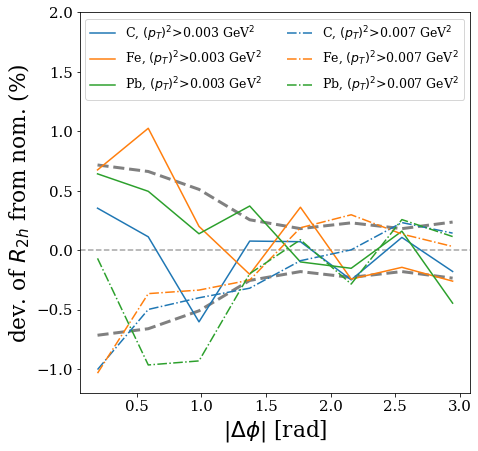

In [124]:
# 1d delta phi pt cut
hists = {}
topo='2pi'
altcut = 0
deltaPhi = misc_util.BinnedVariable("dphi", "$|\Delta\phi|$",np.linspace(0,np.pi,9), "rad")
nom_query = "h1_cm_pt**2 >0.005 and h2_cm_pt**2 > 0.005"
nom_query_trig = "h1_cm_pt**2 >0.005"
devs = []
fig,axs = plt.subplots(1,1,figsize=(7,7))
for altcut in [0.003, 0.007]:
    alt_query = f"h1_cm_pt**2 >{altcut} and h2_cm_pt**2 > {altcut}"
    alt_query_trig = f"h1_cm_pt**2 >{altcut}"
    for color, a in zip("k tab:blue tab:orange tab:green".split(), "D C Fe Pb".split()):
        print(len(dfs_data[f'{a}_{topo}'].query(nom_query))/len(dfs_data[f'{a}_{topo}'])-1)
    
        if a != "D":
            scale = len(dfs_trigger[f'D_{a}'].query(nom_query_trig))/\
                    len(dfs_trigger[f'{a}'].query(nom_query_trig))
            hists[a + "_R2h"] = misc_util.RatioHistogram(deltaPhi, 
                                                     dfs_data[f'{a}_{topo}'].query(nom_query),
                                                     #dfs_mixed[f'{a}_{topo}'],
                                                     dfs_data[f'D_{a}_{topo}'].query(nom_query),
                                                     #dfs_mixed[f'D_{a}_{topo}'],
                                                         scale=scale)

            scale = len(dfs_trigger[f'D_{a}'].query(alt_query_trig))/\
                    len(dfs_trigger[f'{a}'].query(alt_query_trig))
            hists[a + "_R2h_alt"] = misc_util.RatioHistogram(deltaPhi, 
                                                     dfs_data[f'{a}_{topo}'].query(alt_query),
                                                     #dfs_mixed[f'{a}_{topo}'].query(alt_query),
                                                     dfs_data[f'D_{a}_{topo}'].query(alt_query),
                                                     #dfs_mixed[f'D_{a}_{topo}'].query(alt_query),
                                                     scale=scale
                                                     )
            dr1 =  hists[a+"_R2h"]._y/hists[a + "_R2h_alt"]._y-1
            devs.append(dr1)
            dr2 = hists[a+"_R2h"]._dy/hists[a+"_R2h"]._y
            #print(np.sqrt(sum(dr1**2))/8)
            
            plt.errorbar(hists[a+"_R2h"]._xcenter,100*dr1,label=f"{a}, $(p_T)^2$>{altcut} GeV$^2$",color=color, 
                         linestyle=('-' if altcut<0.005 else '-.'))
plt.axhline(0, linestyle='--', color='0.5',alpha=0.7)
plt.gca().set_xlabel(deltaPhi.axis_label())
plt.gca().set_ylabel("dev. of $R_{2h}$ from nom. (%)")

y = []
x = hists['C_R2h']._xcenter
for i in range(8):
    ri = np.sqrt(np.mean([devs[j][i]**2 for j in range(6)]))
    y.append(ri*100)
    print(100*ri)
plt.plot(x,y,color='0.5',linewidth=3,linestyle='--')
plt.plot(x,[-yy for yy in y],color='0.5',linewidth=3,linestyle='--')
plt.legend(fontsize='small',ncol=2)
plt.gca().set_ylim(-1.2, 2)
plt.savefig("images/syst_from_pTcut.png")

6
2.720378499674272
0.3829601527699574
0.29600758545305667
0.41513893491803244
1.1814466316722174
3.9571347589870514
0.8825346271513294
0.20901442303657616
0.13597683758534257
0.36761541625780314
0.8878226833629063
2.457336646220367
0.17002885470445725
0.26286887509570434
0.15422534353802642
0.2485182327455612
0.5535921796588813
3.0840701716272436
0.30304578757402867
0.15294758530867847
0.1813585435223504
0.28879594089265104
0.8076843534387992
2.7982358473052136


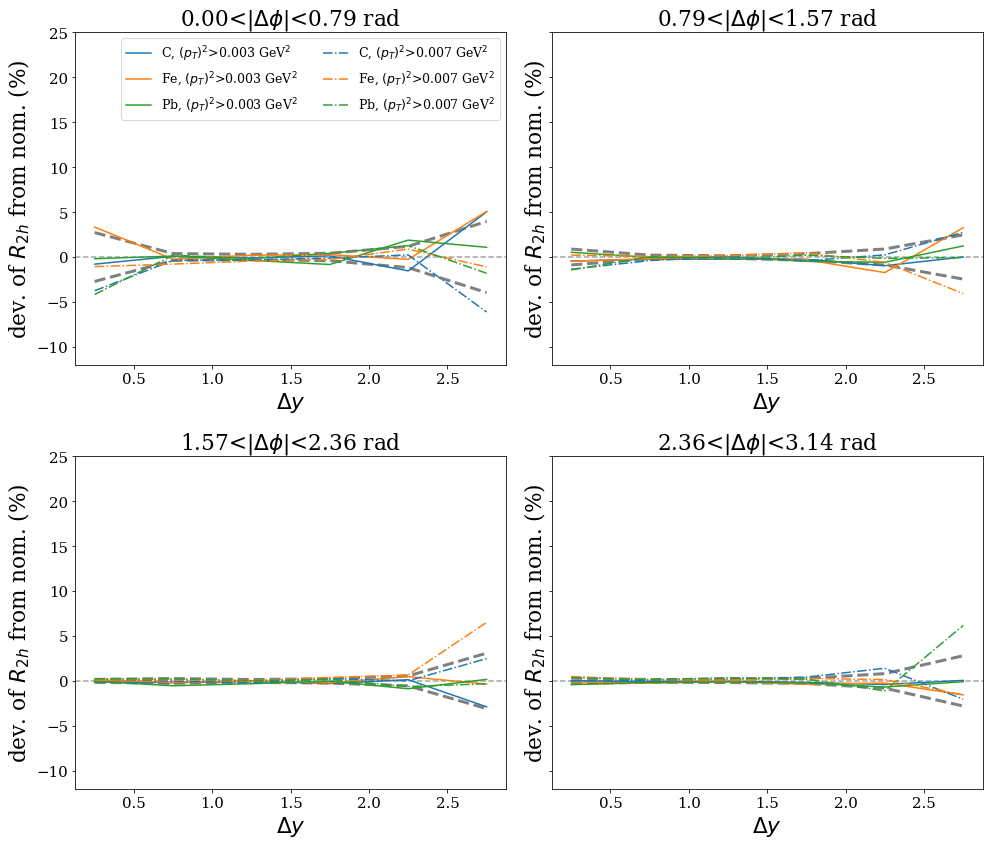

6
13.574991610376403
4.070743271788034
2.378201628849764
1.120844099653873
2.8436532797910496
10.804558717694288
3.6200406433941152
2.1413658713914763
0.8348189171796545
0.8457309323880131
2.3332232922104175
6.700352968575654
0.8323753355105242
0.18189942765288433
0.1283307914686998
0.262982935867723
2.1269842004908384
4.0746820624366915
0.3526388087985083
0.17931048249244383
0.17883104218610224
0.13840989082154137
0.9768872496422781
3.6551278856765865


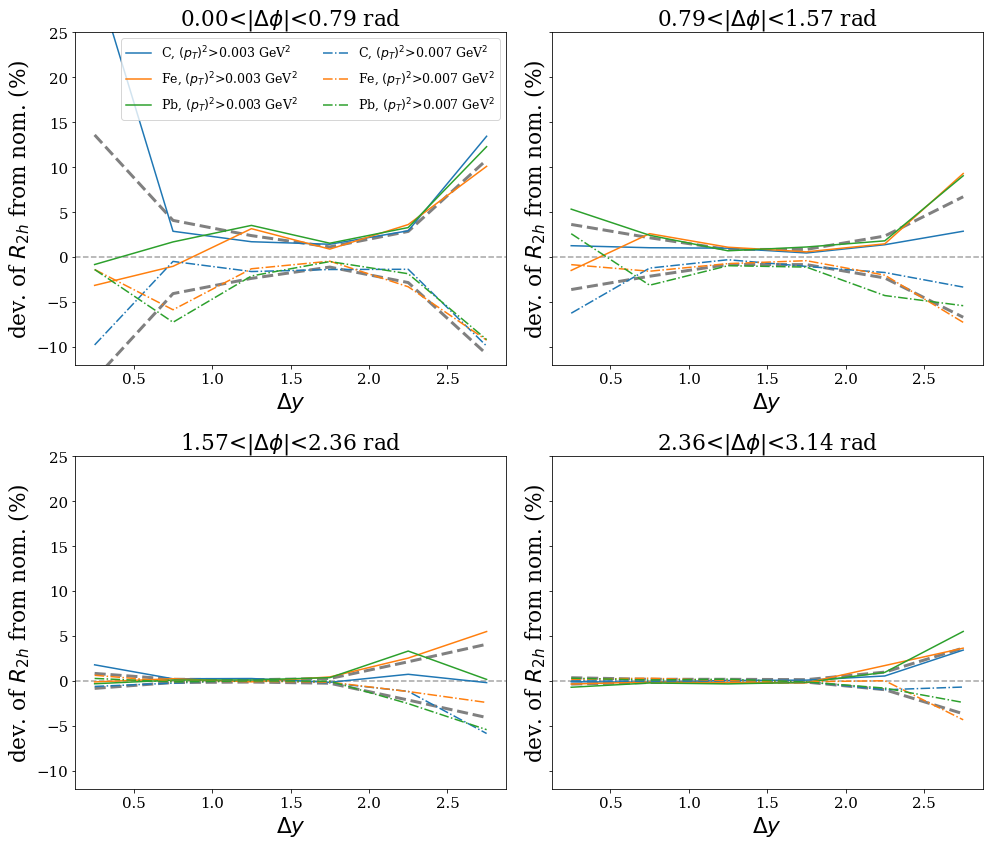

In [134]:
#2d delta phi rapidity pt cut R2h
import imp
imp.reload(misc_util)
for topo in '2pi pi_p'.split():
    altcut = 0
    deltaPhi = misc_util.BinnedVariable("dphi", "$|\Delta\phi|$",np.linspace(0,np.pi,5), "rad")
    deltaY = misc_util.BinnedVariable("drap", "$\Delta y$",np.linspace(0,3.0,7),None)


    nom_query = "h1_cm_pt**2 >0.005 and h2_cm_pt**2 > 0.005"
    nom_query_trig = "h1_cm_pt**2 >0.005"
    devs = []
    fig,axs = plt.subplots(2,2,figsize=(14,12),sharey='all')
    for altcut in [0.003, 0.007]:
        alt_query = f"h1_cm_pt**2 >{altcut} and h2_cm_pt**2 > {altcut}"
        alt_query_trig = f"h1_cm_pt**2 >{altcut}"
        for color, a in zip("k tab:blue tab:orange tab:green".split(), "D C Fe Pb".split()):
            #print(len(dfs_data[f'{a}_{topo}'].query(nom_query))/len(dfs_data[f'{a}_{topo}'])-1)
            if a == "D":
                continue
            dev = []
            for j in range(4):
                plt.sca(axs[j//2][j%2])
                plt.gca().set_title(deltaPhi.slice_label(j))

                scale = len(dfs_trigger[f'D_{a}'].query(nom_query_trig))/\
                        len(dfs_trigger[f'{a}'].query(nom_query_trig))
                hists[a + "_R2h"] = misc_util.RatioHistogram(deltaY, 
                                                         deltaPhi.query(dfs_data[f'{a}_{topo}'].query(nom_query),j),
                                                         #dfs_mixed[f'{a}_{topo}'],
                                                         deltaPhi.query(dfs_data[f'D_{a}_{topo}'].query(nom_query),j),
                                                         #dfs_mixed[f'D_{a}_{topo}'],
                                                             scale=scale)

                scale = len(dfs_trigger[f'D_{a}'].query(alt_query_trig))/\
                        len(dfs_trigger[f'{a}'].query(alt_query_trig))
                hists[a + "_R2h_alt"] = misc_util.RatioHistogram(deltaY, 
                                                         deltaPhi.query(dfs_data[f'{a}_{topo}'].query(alt_query),j),
                                                         #dfs_mixed[f'{a}_{topo}'].query(alt_query),
                                                        deltaPhi.query(dfs_data[f'D_{a}_{topo}'].query(alt_query),j),
                                                         #dfs_mixed[f'D_{a}_{topo}'].query(alt_query),
                                                         scale=scale
                                                         )
                dr1 =  hists[a+"_R2h"]._y/hists[a + "_R2h_alt"]._y-1
                dev+=list(dr1)
                dr2 = hists[a+"_R2h"]._dy/hists[a+"_R2h"]._y
                #print(np.sqrt(sum(dr1**2))/8)

                plt.errorbar(hists[a+"_R2h"]._xcenter,100*dr1,label=f"{a}, $(p_T)^2$>{altcut} GeV$^2$",color=color, 
                             linestyle=('-' if altcut<0.005 else '-.'))
            devs.append(pd.Series(dev))

    y = []
    x = hists['C_R2h']._xcenter
    print(len(devs))
    for i in range(len(devs[0])):
        ri = np.sqrt(np.mean([devs[j][i]**2 for j in range(6)]))
        y.append(ri*100)
        print(100*ri)
    for j in range(4):
        plt.sca(axs[j//2][j%2])
        plt.plot(x,y[j*len(deltaY):(j+1)*len(deltaY)],color='0.5',linewidth=3,linestyle='--')
        plt.plot(x,[-yy for yy in y[j*len(deltaY):(j+1)*len(deltaY)]],color='0.5',linewidth=3,linestyle='--')
        if j == 0:
            plt.legend(fontsize='small',ncol=2)
        plt.axhline(0, linestyle='--', color='0.5',alpha=0.7)
        plt.gca().set_xlabel(deltaY.axis_label())
        plt.gca().set_ylabel("dev. of $R_{2h}$ from nom. (%)")
    plt.gca().set_ylim(-12, 25)
    plt.tight_layout()
    plt.savefig(f"images/syst_from_pTcut_{topo}_2D.png")
    plt.show()

8
3.534199980953787
0.9621076004842393
0.5003062355655641
1.1467255895892667
2.8068861704574126
6.479942628867541
1.0875807703488853
0.4362227477790738
0.4008662012380978
0.8916704711532821
2.7380079338962338
4.334586194150205
0.23029921299880318
0.2577532989598531
0.22213129658060238
0.5098811906872571
1.2201590337475452
2.6206090542866516
0.4662083956108898
0.0554492239774442
0.23635713350332543
0.4280801785951767
0.640238924394652
3.067683478714455


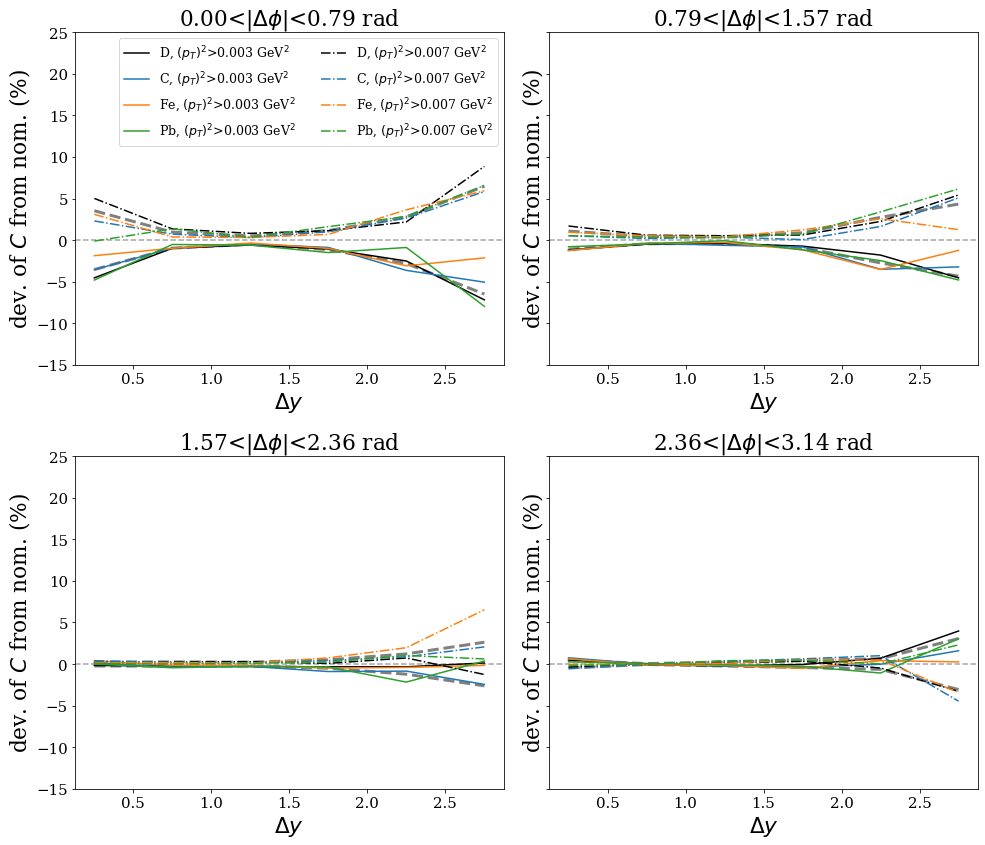

8
4.120030423106169
3.600160994532474
1.8485648188528918
1.085243034735439
3.857291806901949
8.684995093105554
1.3392255100097556
1.864902131278184
1.0992957331342108
0.858203037464792
1.9978449339915372
5.8304360724835105
0.3247129588778352
0.18528364869795277
0.27923052559421857
0.30145450503763566
0.8208041883591983
3.7111735483686714
0.8264562607080934
0.38366487810716415
0.1160744838567879
0.1435970443950537
0.6945379430652174
1.342069533412082


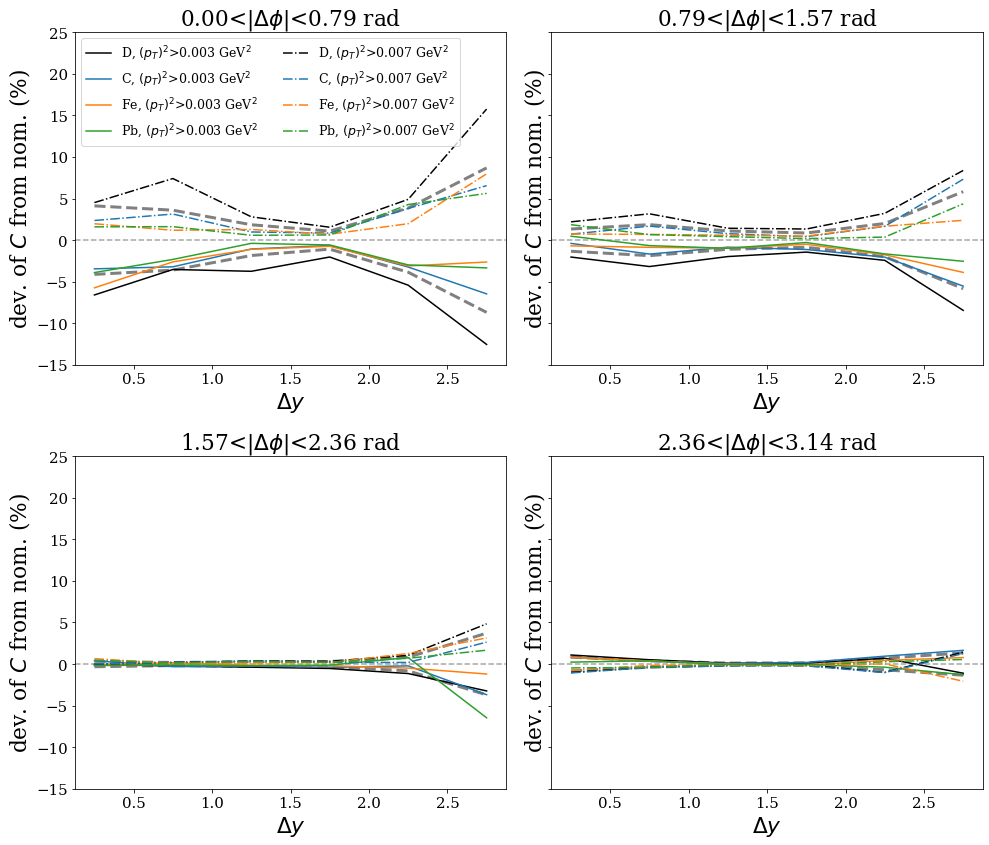

In [149]:
#2d delta phi rapidity pt cut, correlation function
import imp
imp.reload(misc_util)
for topo in '2pi pi_p'.split():
    altcut = 0
    deltaPhi = misc_util.BinnedVariable("dphi", "$|\Delta\phi|$",np.linspace(0,np.pi,5), "rad")
    deltaY = misc_util.BinnedVariable("drap", "$\Delta y$",np.linspace(0,3.0,7), None)


    nom_query = "h1_cm_pt**2 >0.005 and h2_cm_pt**2 > 0.005"
    nom_query_trig = "h1_cm_pt**2 >0.005"
    devs = []
    fig,axs = plt.subplots(2,2,figsize=(14,12),sharey='all')
    for altcut in [0.003, 0.007]:
        alt_query = f"h1_cm_pt**2 >{altcut} and h2_cm_pt**2 > {altcut}"
        alt_query_trig = f"h1_cm_pt**2 >{altcut}"
        for color, a in zip("k tab:blue tab:orange tab:green".split(), "D C Fe Pb".split()):
            #print(len(dfs_data[f'{a}_{topo}'].query(nom_query))/len(dfs_data[f'{a}_{topo}'])-1)
            
            dev = []
            for j in range(4):
                plt.sca(axs[j//2][j%2])
                plt.gca().set_title(deltaPhi.slice_label(j))

                scale = len(dfs_mixed[a].query(nom_query))/\
                        len(dfs_trigger[a].query(nom_query_trig))
                hists[a + "_R2h"] = misc_util.RatioHistogram(deltaY, 
                                                         deltaPhi.query(dfs_data[f'{a}_{topo}'].query(nom_query),j),
                                                         #dfs_mixed[f'{a}_{topo}'],
                                                         deltaPhi.query(dfs_mixed[f'{a}_{topo}'].query(nom_query),j),
                                                         #dfs_mixed[f'D_{a}_{topo}'],
                                                             scale=scale)

                scale = len(dfs_mixed[a].query(alt_query))/\
                        len(dfs_trigger[a].query(alt_query_trig))
                hists[a + "_R2h_alt"] = misc_util.RatioHistogram(deltaY, 
                                                         deltaPhi.query(dfs_data[f'{a}_{topo}'].query(alt_query),j),
                                                         #dfs_mixed[f'{a}_{topo}'].query(alt_query),
                                                        deltaPhi.query(dfs_mixed[f'{a}_{topo}'].query(alt_query),j),
                                                         #dfs_mixed[f'D_{a}_{topo}'].query(alt_query),
                                                         scale=scale
                                                         )
                dr1 =  hists[a+"_R2h"]._y/hists[a + "_R2h_alt"]._y-1
                dev+=list(dr1)
                dr2 = hists[a+"_R2h"]._dy/hists[a+"_R2h"]._y
                #print(np.sqrt(sum(dr1**2))/8)

                plt.errorbar(hists[a+"_R2h"]._xcenter,100*dr1,label=f"{a}, $(p_T)^2$>{altcut} GeV$^2$",color=color, 
                             linestyle=('-' if altcut<0.005 else '-.'))
            devs.append(pd.Series(dev))
        

    y = []
    x = hists['C_R2h']._xcenter
    print(len(devs))
    for i in range(len(devs[0])):
        ri = np.sqrt(np.mean([devs[j][i]**2 for j in range(len(devs))]))
        y.append(ri*100)
        print(100*ri)
    for j in range(4):
        plt.sca(axs[j//2][j%2])
        plt.plot(x,y[j*len(deltaY):(j+1)*len(deltaY)],color='0.5',linewidth=3,linestyle='--')
        plt.plot(x,[-yy for yy in y[j*len(deltaY):(j+1)*len(deltaY)]],color='0.5',linewidth=3,linestyle='--')
        if j == 0:
            plt.legend(fontsize='small',ncol=2)
        plt.axhline(0, linestyle='--', color='0.5',alpha=0.7)
        plt.gca().set_xlabel(deltaY.axis_label())
        plt.gca().set_ylabel("dev. of $C$ from nom. (%)")
    plt.tight_layout()
    plt.gca().set_ylim(-15, 25)
    plt.savefig(f"images/syst_from_pTcut_{topo}_2D_corr.png")
    plt.show()

8
0.7087786356341903
0.42788480779796156
0.17891280118397326
0.5420148360391819
0.5434207830844913
1.0837992139642882
1.0415978848345921
0.5432946183062203
0.1682128930596549
0.3655857634517252
0.4149085334202852
0.7353288884366426
0.5762756052648254
0.19580777678454253
0.18916446277868892
0.5221501327792157
0.351314176711848
1.513689850084285
0.8274834591262887
0.15348934356565525
0.5409705919199567
0.3734291102516444
0.6637977052067494
0.8776533341449251


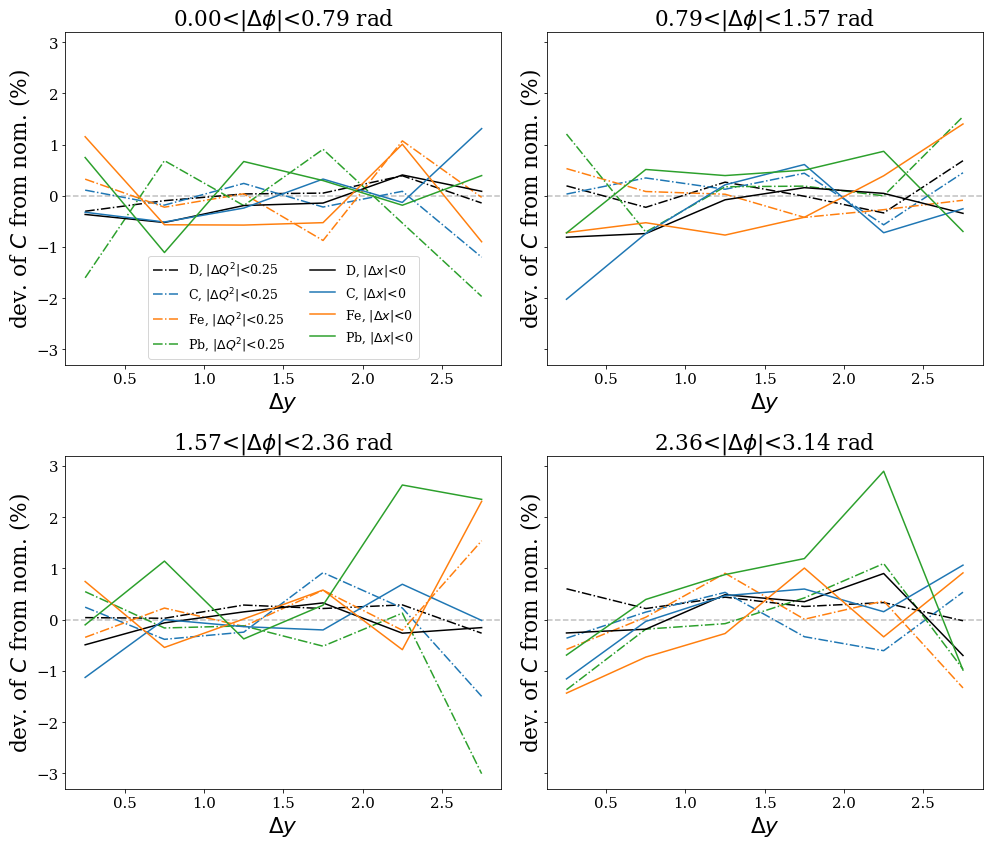

8
0.7003309859094807
0.2211320161174733
0.3481391436879158
0.14468819961573898
0.180939483049657
0.6035139010501338
1.1159616757286606
0.2574325688213971
0.244204963786249
0.17854123689751558
0.23781091161419743
0.5494789774180249
0.9494239161077481
0.3615747410500951
0.25584112515846874
0.14111683333786826
0.39880265098824796
0.6716181730338153
0.93826665489194
0.5754119813898627
0.23949644033552006
0.20554435498860618
0.2673347702693925
0.748625484352669


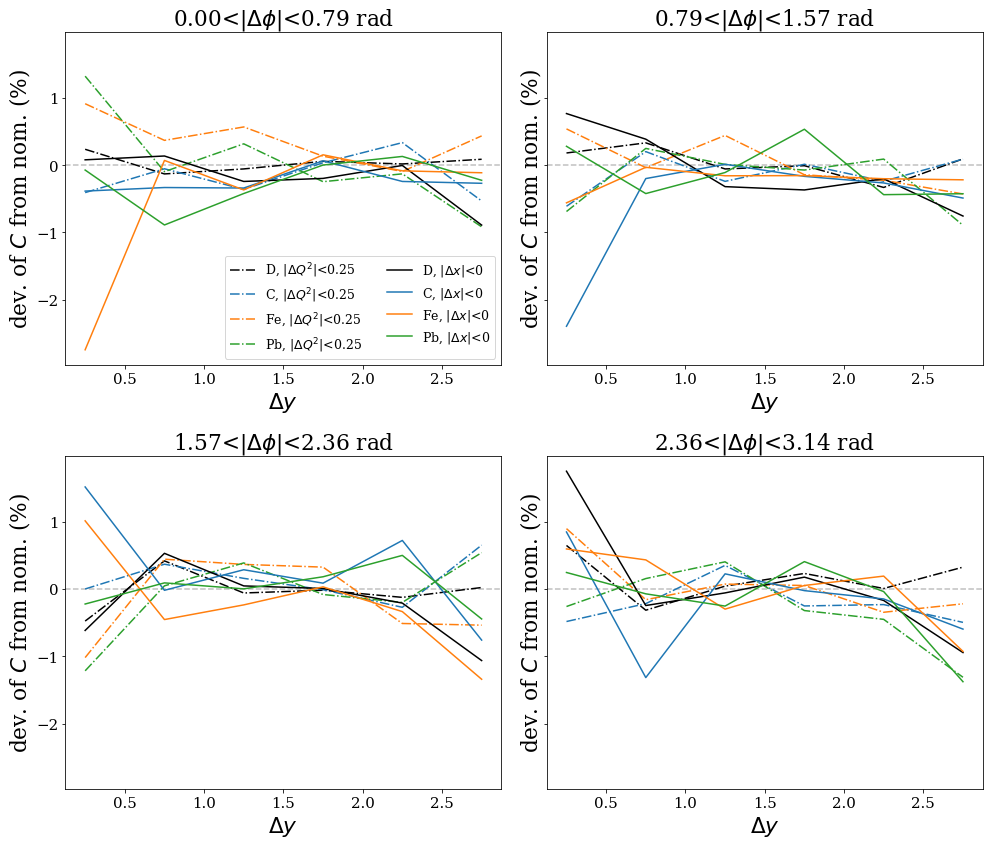

In [138]:
#2d delta phi rapidity event mixing, correlation function
import imp
imp.reload(misc_util)
for topo in '2pi pi_p'.split():
    altcut = 0
    deltaPhi = misc_util.BinnedVariable("dphi", "$|\Delta\phi|$",np.linspace(0,np.pi,5), "rad")
    deltaY = misc_util.BinnedVariable("drap", "$\Delta y$",np.linspace(0,3.0,7), None)


    nom_query = "h1_cm_pt**2 >0.005 and h2_cm_pt**2 > 0.005"
    nom_query_trig = "h1_cm_pt**2 >0.005"
    devs = []
    fig,axs = plt.subplots(2,2,figsize=(14,12),sharey='all')
    for alt_query,alt_name in [["abs(mixevt_Q2-Q2)<0.25", "$|\\Delta Q^2|$<0.25"], ["abs(mixevt_x-x)<0.04","$|\\Delta x|$<0"]]:
        for color, a in zip("k tab:blue tab:orange tab:green".split(), "D C Fe Pb".split()):
            #print(len(dfs_data[f'{a}_{topo}'].query(nom_query))/len(dfs_data[f'{a}_{topo}'])-1)
            
            dev = []
            for j in range(4):
                plt.sca(axs[j//2][j%2])
                plt.gca().set_title(deltaPhi.slice_label(j))

                scale = len(dfs_mixed[a].query(nom_query))/\
                        len(dfs_trigger[a].query(nom_query_trig))
                hists[a + "_R2h"] = misc_util.RatioHistogram(deltaY, 
                                                         deltaPhi.query(dfs_data[f'{a}_{topo}'].query(nom_query),j),
                                                         #dfs_mixed[f'{a}_{topo}'],
                                                         deltaPhi.query(dfs_mixed[f'{a}_{topo}'].query(nom_query),j),
                                                         #dfs_mixed[f'D_{a}_{topo}'],
                                                             scale=scale)

                scale = len(dfs_mixed[a].query(nom_query+" and "+alt_query))/\
                        len(dfs_trigger[a].query(nom_query_trig))
                hists[a + "_R2h_alt"] = misc_util.RatioHistogram(deltaY, 
                                                         deltaPhi.query(dfs_data[f'{a}_{topo}'].query(nom_query),j),
                                                         #dfs_mixed[f'{a}_{topo}'].query(alt_query),
                                                        deltaPhi.query(dfs_mixed[f'{a}_{topo}'].query(nom_query+" and "+alt_query),j),
                                                         #dfs_mixed[f'D_{a}_{topo}'].query(alt_query),
                                                         scale=scale
                                                         )
                dr1 =  hists[a+"_R2h"]._y/hists[a + "_R2h_alt"]._y-1
                dev+=list(dr1)
                dr2 = hists[a+"_R2h"]._dy/hists[a+"_R2h"]._y
                #print(np.sqrt(sum(dr1**2))/8)

                plt.errorbar(hists[a+"_R2h"]._xcenter,100*dr1,label=f"{a}, {alt_name}",color=color, 
                             linestyle=('-' if 'x' in alt_name else '-.'))
            devs.append(pd.Series(dev))
        

    y = []
    x = hists['C_R2h']._xcenter
    print(len(devs))
    for i in range(len(devs[0])):
        ri = np.sqrt(np.mean([devs[j][i]**2 for j in range(6)]))
        y.append(ri*100)
        print(100*ri)
    for j in range(4):
        plt.sca(axs[j//2][j%2])
        #plt.plot(x,y[j*len(deltaY):(j+1)*len(deltaY)],color='0.5',linewidth=3,linestyle='--')
        #plt.plot(x,[-yy for yy in y[j*len(deltaY):(j+1)*len(deltaY)]],color='0.5',linewidth=3,linestyle='--')
        if j == 0:
            plt.legend(fontsize='small',ncol=2)
        plt.axhline(0, linestyle='--', color='0.5',alpha=0.5)
        plt.gca().set_xlabel(deltaY.axis_label())
        plt.gca().set_ylabel("dev. of $C$ from nom. (%)")
    #plt.gca().set_ylim(-15, 25)
    plt.tight_layout()
    plt.savefig(f"images/syst_from_mixing_{topo}_2D_corr.png")
    plt.show()

2.2350033267759373
2.3230786247657367
2.2350033267759373
2.3230786247657367
2.2350033267759373
2.3230786247657367
2.2350033267759373
2.3230786247657367
2.7626227295257446
2.8626033138174214
2.7626227295257446
2.8626033138174214
2.7626227295257446
2.8626033138174214
2.7626227295257446
2.8626033138174214
1.8312829842577696
1.8982226671263027
1.8312829842577696
1.8982226671263027
1.8312829842577696
1.8982226671263027
1.8312829842577696
1.8982226671263027
2.360099597968334
2.439441135216861
2.360099597968334
2.439441135216861
2.360099597968334
2.439441135216861
2.360099597968334
2.439441135216861
4
4.243317683919462
4.8459729083407925
5.347963135843883
3.970104493156642
3.274911013314849
4.97633964837334
4.17788348470227
4.6427275628760185
4.008712287216518
4.603779481180834
4.00314438246452
3.9975933777712127
4.425882149694183
4.069943921169554
3.9394112468095694
3.9944694556302207
4.268440443208623
4.135285548809272
4.517333305894387
3.709978719346655
3.0683480633159066
4.795474531608105

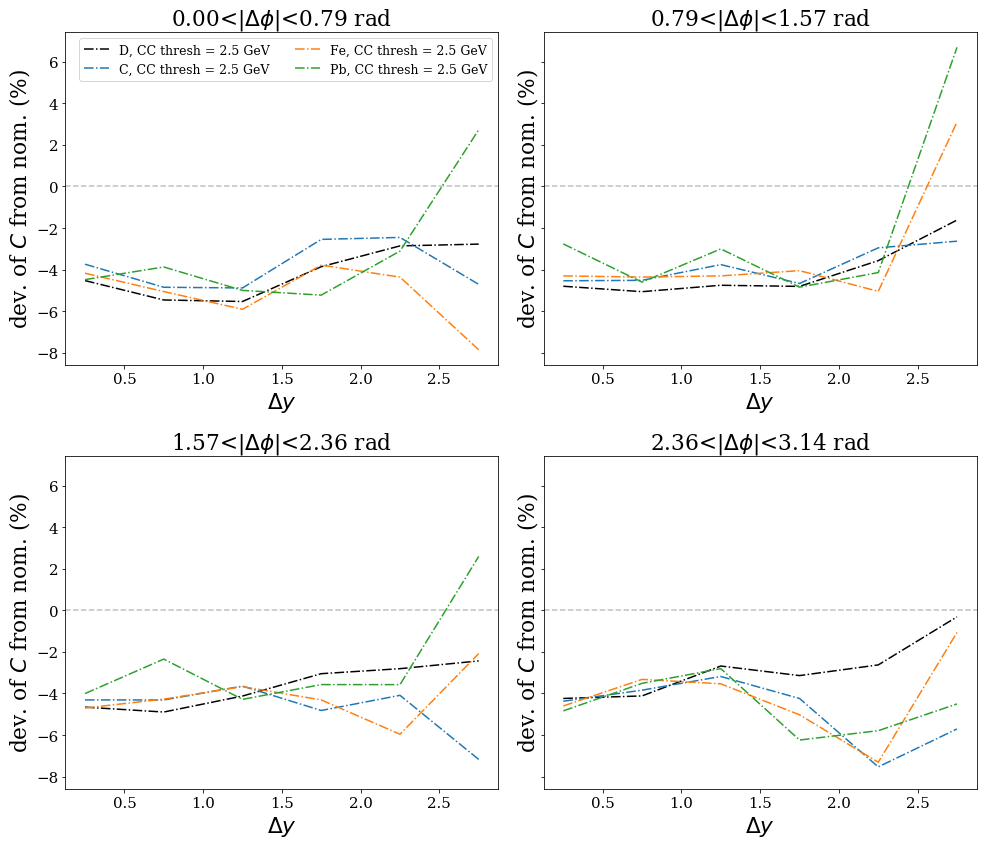

In [148]:
# correlations, 2D, systematic from cerenkov threshold
import imp
imp.reload(misc_util)
for topo in '2pi'.split():
    altcut = 0
    deltaPhi = misc_util.BinnedVariable("dphi", "$|\Delta\phi|$",np.linspace(0,np.pi,5), "rad")
    deltaY = misc_util.BinnedVariable("drap", "$\Delta y$",np.linspace(0,3.0,7), None)


    nom_query = "h1_cm_pt**2 >0.005 and h2_cm_pt**2 > 0.005"
    nom_query_trig = "h1_cm_pt**2 >0.005"
    devs = []
    fig,axs = plt.subplots(2,2,figsize=(14,12),sharey='all')
    for alt_query,alt_name in [[R2h_module.pair_cut_nom.replace("2.7","2.5"), "CC thresh = 2.5 GeV"]]:
        for color, a in zip("k tab:blue tab:orange tab:green".split(), "D C Fe Pb".split()):
            #print(len(dfs_data[f'{a}_{topo}'].query(nom_query))/len(dfs_data[f'{a}_{topo}'])-1)
            
            dev = []
            for j in range(4):
                plt.sca(axs[j//2][j%2])
                plt.gca().set_title(deltaPhi.slice_label(j))

                scale = len(dfs_mixed[a].query(nom_query).query(R2h_module.pair_cut_nom))/\
                        len(dfs_trigger[a].query(nom_query_trig).query(R2h_module.trigger_cut_nom))
                print(scale)
                hists[a + "_R2h"] = misc_util.RatioHistogram(deltaY, 
                                                         deltaPhi.query(dfs_data[f'{a}_{topo}'].query(nom_query).query(R2h_module.pair_cut_nom),j),
                                                         #dfs_mixed[f'{a}_{topo}'],
                                                         deltaPhi.query(dfs_mixed[f'{a}_{topo}'].query(nom_query).query(R2h_module.pair_cut_nom),j),
                                                         #dfs_mixed[f'D_{a}_{topo}'],
                                                             scale=scale)
                alt_query_trig = R2h_module.trigger_cut_nom.replace("2.7","2.5")
                scale = len(dfs_mixed[a].query(nom_query).query(alt_query))/\
                        len(dfs_trigger[a].query(nom_query_trig).query(alt_query_trig))
                print(scale)
                hists[a + "_R2h_alt"] = misc_util.RatioHistogram(deltaY, 
                                                         deltaPhi.query(dfs_data[f'{a}_{topo}'].query(nom_query+" and "+alt_query),j),
                                                         #dfs_mixed[f'{a}_{topo}'].query(alt_query),
                                                        deltaPhi.query(dfs_mixed[f'{a}_{topo}'].query(nom_query+" and "+alt_query),j),
                                                         #dfs_mixed[f'D_{a}_{topo}'].query(alt_query),
                                                         scale=scale
                                                         )
                dr1 =  hists[a+"_R2h"]._y/hists[a + "_R2h_alt"]._y-1
                dev+=list(dr1)
                dr2 = hists[a+"_R2h"]._dy/hists[a+"_R2h"]._y
                #print(np.sqrt(sum(dr1**2))/8)

                plt.errorbar(hists[a+"_R2h"]._xcenter,100*dr1,label=f"{a}, {alt_name}",color=color, 
                             linestyle=('-' if 'x' in alt_name else '-.'))
            devs.append(pd.Series(dev))
        

    y = []
    x = hists['C_R2h']._xcenter
    print(len(devs))
    for i in range(len(devs[0])):
        ri = np.sqrt(np.mean([devs[j][i]**2 for j in range(len(devs))]))
        y.append(ri*100)
        print(100*ri)
    for j in range(4):
        plt.sca(axs[j//2][j%2])
        #plt.plot(x,y[j*len(deltaY):(j+1)*len(deltaY)],color='0.5',linewidth=3,linestyle='--')
        #plt.plot(x,[-yy for yy in y[j*len(deltaY):(j+1)*len(deltaY)]],color='0.5',linewidth=3,linestyle='--')
        if j == 0:
            plt.legend(fontsize='small',ncol=2)
        plt.axhline(0, linestyle='--', color='0.5',alpha=0.5)
        plt.gca().set_xlabel(deltaY.axis_label())
        plt.gca().set_ylabel("dev. of $C$ from nom. (%)")
    #plt.gca().set_ylim(-15, 25)
    plt.tight_layout()
    plt.savefig(f"images/syst_from_cerenkov_{topo}_2D_corr.png")
    plt.show()

3
0.8678692126610308
1.4006405108794917
0.6864192019115842
0.8550040351512477
1.891989733679178
5.0033781878609505
1.672683890060913
1.049979160924315
1.4300651653734802
0.6972383192159377
0.23557442633894676
5.919764363020442
0.4926685097481922
1.4231834948974817
0.6842038104811288
1.249353633860232
2.263597385514252
4.820402897237921
0.3477808412947472
0.5081185128503127
0.6120830621481406
1.307146156407416
2.942830008251047
4.5194823869469


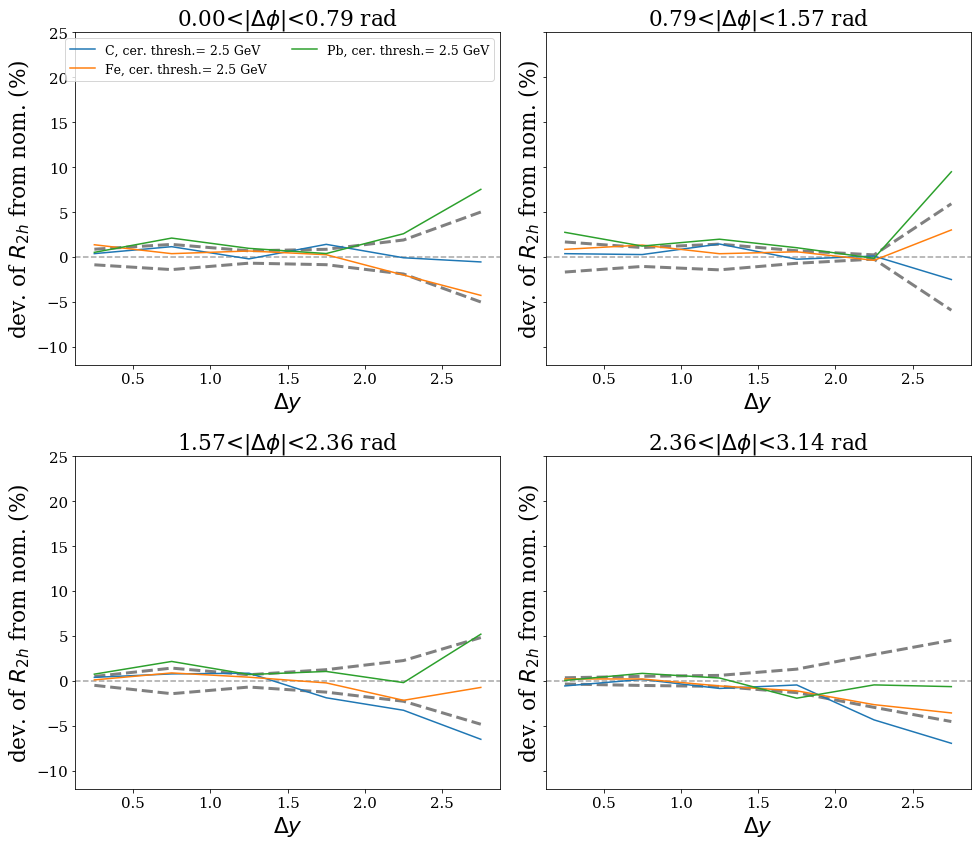

3
0.6012299853148487
1.1111409352217838
1.7122181729675778
2.1771359948127897
2.3380553197352034
3.9537458573310604
0.6012299853148447
1.0101568243388899
2.1050501037102953
2.9486699948373034
4.019079775749939
5.866046466605315
0.6012299853148376
0.7049010261955888
1.5716371351248144
1.666274306929714
2.032030687297165
3.8288025447531697
0.9433180586490699
0.9630838699363292
1.1359757870130924
0.4116158467137447
2.4419187764451897
2.9998343005415085


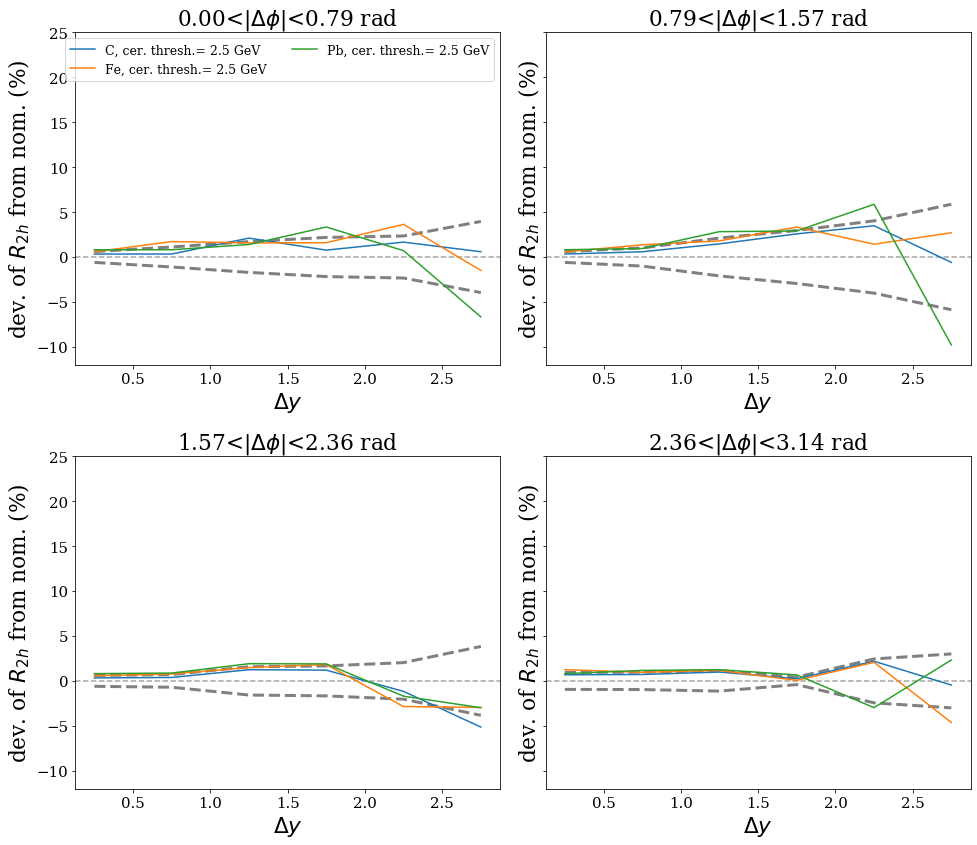

In [156]:
#2d delta phi rapidity pt cut R2h
import imp
imp.reload(misc_util)
for topo in '2pi pi_p'.split():
    altcut = 0
    deltaPhi = misc_util.BinnedVariable("dphi", "$|\Delta\phi|$",np.linspace(0,np.pi,5), "rad")
    deltaY = misc_util.BinnedVariable("drap", "$\Delta y$",np.linspace(0,3.0,7),None)


    nom_query = "h1_cm_pt**2 >0.005 and h2_cm_pt**2 > 0.005"
    nom_query_trig = "h1_cm_pt**2 >0.005"
    devs = []
    fig,axs = plt.subplots(2,2,figsize=(14,12),sharey='all')
    for alt_query,alt_name in [[R2h_module.pair_cut_nom.replace("2.7","2.5"), "CC thresh = 2.5 GeV"]]:
        for color, a in zip("k tab:blue tab:orange tab:green".split(), "D C Fe Pb".split()):
            #print(len(dfs_data[f'{a}_{topo}'].query(nom_query))/len(dfs_data[f'{a}_{topo}'])-1)
            if a == "D":
                continue
            dev = []
            for j in range(4):
                plt.sca(axs[j//2][j%2])
                plt.gca().set_title(deltaPhi.slice_label(j))
                alt_query="(" + nom_query+") and ("+ alt_query + ")"
                
                scale = len(dfs_trigger[f'D_{a}'].query(nom_query_trig).query(R2h_module.trigger_cut_nom))/\
                        len(dfs_trigger[f'{a}'].query(nom_query_trig).query(R2h_module.trigger_cut_nom))
                hists[a + "_R2h"] = misc_util.RatioHistogram(deltaY, 
                                                         deltaPhi.query(dfs_data[f'{a}_{topo}'].query(nom_query).query(R2h_module.pair_cut_nom),j),
                                                         #dfs_mixed[f'{a}_{topo}'],
                                                         deltaPhi.query(dfs_data[f'D_{a}_{topo}'].query(nom_query).query(R2h_module.pair_cut_nom),j),
                                                         #dfs_mixed[f'D_{a}_{topo}'],
                                                             scale=scale)
                alt_query_trig = nom_query_trig +" and ("+R2h_module.trigger_cut_nom.replace("2.7","2.5")+")"
                scale = len(dfs_trigger[f'D_{a}'].query(alt_query_trig))/\
                        len(dfs_trigger[f'{a}'].query(alt_query_trig))
                hists[a + "_R2h_alt"] = misc_util.RatioHistogram(deltaY, 
                                                         deltaPhi.query(dfs_data[f'{a}_{topo}'].query(alt_query),j),
                                                         #dfs_mixed[f'{a}_{topo}'].query(alt_query),
                                                        deltaPhi.query(dfs_data[f'D_{a}_{topo}'].query(alt_query),j),
                                                         #dfs_mixed[f'D_{a}_{topo}'].query(alt_query),
                                                         scale=scale
                                                         )
                dr1 =  hists[a+"_R2h"]._y/hists[a + "_R2h_alt"]._y-1
                dev+=list(dr1)
                dr2 = hists[a+"_R2h"]._dy/hists[a+"_R2h"]._y
                #print(np.sqrt(sum(dr1**2))/8)

                plt.errorbar(hists[a+"_R2h"]._xcenter,100*dr1,label=f"{a}, cer. thresh.= 2.5 GeV",color=color, 
                             linestyle=('-' if altcut<0.005 else '-.'))
            devs.append(pd.Series(dev))

    y = []
    x = hists['C_R2h']._xcenter
    print(len(devs))
    for i in range(len(devs[0])):
        ri = np.sqrt(np.mean([devs[j][i]**2 for j in range(3)]))
        y.append(ri*100)
        print(100*ri)
    for j in range(4):
        plt.sca(axs[j//2][j%2])
        plt.plot(x,y[j*len(deltaY):(j+1)*len(deltaY)],color='0.5',linewidth=3,linestyle='--')
        plt.plot(x,[-yy for yy in y[j*len(deltaY):(j+1)*len(deltaY)]],color='0.5',linewidth=3,linestyle='--')
        if j == 0:
            plt.legend(fontsize='small',ncol=2)
        plt.axhline(0, linestyle='--', color='0.5',alpha=0.7)
        plt.gca().set_xlabel(deltaY.axis_label())
        plt.gca().set_ylabel("dev. of $R_{2h}$ from nom. (%)")
    plt.gca().set_ylim(-12, 25)
    plt.tight_layout()
    plt.savefig(f"images/syst_from_cerenkov_{topo}_2D.png")
    plt.show()